<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/leoenge/Lab-5/leoenge_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 5: Integration**
**Leo Enge**

# **Abstract**

In this report we tested some different numerical methods for integration over both the unit interval and the reference triangle. Both the Gauss quadrature and the Monte-Carlo integration was used over both domains. The methods were then tested for random polynomials. Just as the theory states the Gauss quadrature was exact for polynomials of small enough degree and the Monte-Carlo had a convergence rate of $1/\sqrt{n}$, where $n$ is the number of quadrature points used.

#**About the code**

In [1]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Leo Enge (leoe@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad, dblquad

# **Introduction**

In this report we aim to test some different numerical methods for calculating an integral over both a unit interval and a reference triangle.

We use the 2-point Gauss method for integration over the unit interval $[0,1]$. This method is constructed so that it will be exact for polynomials of degree 3 or less. We therefore test the method for a set of random polynomails of degree 3 or less.

Then we use the 3-point Gauss method for integration over the reference triangle, i.e. the triangle enclosed by the points $(0,1), (1,0)$ and $(0,1)$. This in turn is constructed so to be exact for polynomials of two variables and of degree 2 or less. So we test the method for a random set of such polynomials.

Finally we use the stochastic method of Monte-Carlo integration over both the unit interval and the reference triangle and then test both of these methods for the same kinds of polynomials as used before.


# **Methods**

## Gauss 2-point Integration

The "ordinary" 2-point Gauss quadrature is over the interval $[-1,1]$, where the weights are $w_0 = w_1 = 1$ and the quadrature points are $x_0,1 = \pm \frac{1}{\sqrt{3}}$, and the integral is calculated by 
\begin{equation}
\sum_{j=0}^1 f(x_j) w_j
\end{equation}


 We begin by implementing this quadrature. We can then calculate the integral over the interval $[0,1]$ by a simple change of variable $x \mapsto 2x - 1$. In other words the integral becomes
\begin{equation}
\int_0^1 f(x) dx = \frac{1}{2} \int_{-1}^{1} f\left(\frac{x+1}{2}\right) dx
\end{equation} 
where the right hand side can be calculated using the ordinary 2-point Gauss quadrature.

We can even generalise this to an arbitrary interval $[a,b]$, by the change of variable 
\begin{equation}
x \mapsto 2 \frac{x-a}{b-a} - 1
\end{equation}
which leads to the integral
\begin{equation}
\int_a^b f(x) dx = \frac{b-a}{2} \int_{-1}^{1} f\left( \frac{(x+1)(b-a)}{2} + a\right) dx
\end{equation}


In [0]:
def gauss_int(f, a=-1, b=1):
  if not (a==-1 and b==1):
    #Calling the function again, but with the variables changed.
    return ((b-a)/2)*gauss_int(lambda x: f((x+1) * (b-a) * (1/2) + a))

  s = 0
  w = 1
  point = 1/(np.sqrt(3))
  for x in [point, -point]:
    s += f(x)*w
  return s


### Test the Gauss integration
We test the Gauss integration agains the exact integral for a large set of random cubic polynomials.  

#### Generate random cubic polynomial
We begi by defining a function which generates a ranom cubic polynomial
\begin{equation}
p(x) = c_0 + c_1x + c_2x^2 + c_3x^3.
\end{equation}
The function returns both the polynomial and an array with the coefficients which will be used to calculate the exact integral.


In [0]:
def random_cubic_polynomial_1d():
  coefficients = np.around(5*np.random.rand(4), 1)
  def p(x):
    y = 0
    for i in range(4):
      y += coefficients[i]* (x**i)
    return y
  return p, coefficients

#### Exact integral
If we have a polynomial
\begin{equation}
p(x) = c_0 + c_1x + c_2x^2 + c_3x^3.
\end{equation}
we can easily calculate the exact integral over the unit interval $[0,1]$ as
\begin{equation}
\int_0^1 p(x) \ dx = c_0 + \frac{c_1}{2} + \frac{c_2}{3} + \frac{c_3}{4}
\end{equation}

In [0]:
def exact_integral_int(coefficients):
  integral = 0
  for i in range(4):
    integral += coefficients[i]/(i+1)
  return integral

#### The test
We now test the Gauss integration for a set of $100$ random polynomials of degree 3 or less. We then compare it to the exact integral and print this error for each polynomial. We also calculate the average of the errors and and print it.

In [0]:
def test_gauss_int():
  decimals = 10
  no_of_tests = 100
  errors = np.zeros(no_of_tests)
  for i in range(no_of_tests):
    p, coef = random_cubic_polynomial_1d()
    error = abs(gauss_int(p, a=0, b=1) - exact_integral_int(coef))
    errors[i] = np.around(error, decimals)
  print("Errors for each test of " + str(no_of_tests) + " tests:")
  print(str(errors))
  print("The average error is: " + str(np.around(np.mean(errors), decimals)))

## 3-point Quadrature over Triangle
We implement the 3-point Gauss quadrature over the reference triangle, i.e. the triangle enclosed by the points $(0,0), (1,0)$ and $(0,1)$, as suggested by Example 11.5 of the lecture notes, with the quadrature points
\begin{align}
x_0 = (0, 1/2) \\
x_1 = (1/2, 0) \\
x_2 = (1/2, 1/2)
\end{align}
and the weights $w_0 = w_1 = w_2 = 1/6$. Just as in one variable, the integral is calculated by
\begin{equation}
\sum_{j=0}^2 f(x_j, y_j) w_j
\end{equation}

In [0]:
def gauss_tri(f):
  quad_points = [(0.5, 0), (0, 0.5), (0.5, 0.5)]
  w = 1/6
  s = 0
  for x in quad_points:
    s += f(x[0], x[1])*w
  return s

### Test the quadrature over a reference triangle
Just as for the unit interval, we generate a large set of polynomials, now of two variables and of degree 2 or less, and compare the Gauss method against the exact integral.

#### Generate a random polynomial
We generate a random quadratic polynomial of two variables. The polynomail is of the form
\begin{equation}
p(x,y) = c_0 + c_1x + c_2y + c_3xy + c_4 x^2 + c_5y^2
\end{equation}

For calculating the exact integral, we not only return the function $p(x,y)$, but also the coefficients $c_i$.



In [0]:
def random_quad_polynomial_2d():
  c = np.around(5*np.random.rand(6), 1)
  def p(x,y):
    return c[0] + c[1]*x + c[2]*y + c[3]*x*y + c[4]*(x**2) + c[5]*(y**2)
  return p, c

#### The exact integral
One can by simple rules of integration rules derive the following formula
\begin{equation}
\int_0^1 \int_0^{1-y} c_0 + c_1x + c_2y + c_3xy + c_4 x^2 + c_5y^2 \ dx dy = \frac{c_0}{2} + \frac{c_1 + c_2}{6} + \frac{c_3}{24} +\frac{c_4 + c_5}{12}.
\end{equation}
We use this formula to calculate the exact integral.

In [0]:
def exact_integral_tri(c):
  return (c[0]/2) + (c[1]/6) + (c[2]/6) + (c[3]/24) + (c[4]/12) + (c[5]/12)

#### Test of exact integration formula
Just to make sure that the formula for calculating the exact integral is correct, we compare the result to that of scipys quadrature function. If the formula is correct these two should be very close.

In [0]:
def test_test():
  no_of_tests = 10
  errors = np.zeros(no_of_tests)
  for i in range(no_of_tests):
    p, c = random_quad_polynomial_2d()
    scipy_quad = dblquad(lambda u,v: p(u,v), 0, 1, lambda x: 0, lambda x: 1-x)[0]
    exact = exact_integral_tri(c)
    errors[i] = abs(scipy_quad - exact)
  print("Difference beetween exact integration and scipys dblquad: ")
  print(str(errors))

In [11]:
test_test()

Difference beetween exact integration and scipys dblquad: 
[0.0000000e+00 0.0000000e+00 0.0000000e+00 4.4408921e-16 4.4408921e-16
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]


We see that they are indeed very close. So we conclude that the exact integration formula is correct.

#### The test
The test is analogous to the one for the unit interval.

In [0]:
def test_gauss_tri():
  decimals = 10
  no_of_tests = 100
  errors = np.zeros(no_of_tests)
  for i in range(no_of_tests):
    p,c = random_quad_polynomial_2d()
    errors[i] = np.around((abs(exact_integral_tri(c) - gauss_tri(p))), decimals)
  print("Errors for each test of " + str(no_of_tests) + " tests:")
  print(str(errors))
  print("The average error is: " + str(np.around(np.mean(errors), decimals)))

## Monte-Carlo Quadrature Over Unit Interval
For a function $f: [0,1] \to \mathbb{R}$ we can approximate the integral of $f$ on $[0,1]$ by
\begin{equation}
\int_0^1 f(x) \ dx \approx \frac{1-0}{n} \sum_{i=1}^n f(x_i)
\end{equation}
where $x_i$ is some random point in $[0,1]$, and $n$ is the number of points, used.

In [0]:
def mc_int(f, no_of_points):
  s = 0
  interval_length = 1
  for _ in range(no_of_points):
    quad_point = np.random.rand(1)
    s += interval_length * f(quad_point)
  return (s/no_of_points)

#### Test Monte-Carlo integration
We test the Monte-Carlo integration for 100 different random cubic polynomials $f(x)$ and for different numbers, $n$, of quadrature points. For each of the polynomials we calculate the error
\begin{equation}
e_{f(x)}(n) = \left| \int_0^1 f(x) \ dx -  \frac{1-0}{n} \sum_{i=1}^n f(x_i) \right|
\end{equation}
as a function of how many random quadrature points that are used. When then take the average of all the $e_{f_i}(n)$ for all the random polynomials $f_i$ used and plot it in blue against $n$.

We also plot $1/\sqrt(n)$ in red for comparison.

In [0]:
def test_mc_int():
  no_of_tests = 100
  n = np.array([3, 4, 5, 8, 10, 15, 20, 25, 30, 50, 100, 150])
  x = np.linspace(n[0], n[-1], num=100)
  average_error = np.zeros(n.size)  
  for i in range(no_of_tests):
    errors = np.zeros(n.size)
    p,c = random_cubic_polynomial_1d()
    for j in range(n.size):
      errors[j] = abs(exact_integral_int(c) - mc_int(p, n[j]))
    average_error += errors
    #print(average_error)
    #plt.plot(n, errors, color='blue')
  average_error = average_error/no_of_tests
  line1, = plt.plot(n, 1/np.sqrt(n), color='red', label='1/sqrt(n)')
  line2, = plt.plot(n, average_error, color='blue', label='Average error of 1D MC')
  plt.title("Plot of average error and of 1/sqrt(n) against number of random quadrature points n")
  first_legend = plt.legend(handles=[line1, line2], loc='upper right')
  ax = plt.gca().add_artist(first_legend)


## Monte-Carlo Integration over Reference Triangle
We can generalise the approximation we just did over an interval $[0,1]$ to be over any domain $D$. Let $f: D \to \mathbb{R}$, we then get the approximation
\begin{equation}
\int_D f(x) \ dx \approx \frac{|D|}{n} \sum_{i=1}^n f(x_i)
\end{equation}
for $n$ number of random points $x_i \in D$.

In [0]:
def mc_tri(f, no_of_points):
  s = 0
  area = 1/2
  i = 0
  while(i<no_of_points) :
    quad_point = np.random.rand(2)
    if (quad_point[0] + quad_point[1] > 1):
      continue
    i += 1
    s += area * f(quad_point[0], quad_point[1])
  return (s/no_of_points)

### Test Monte-Carlo Integration over Reference Triangle
We test it in much the same way as in the one-dimensional case over an interval. We use the previously defined functions for generating a random quadratic polynomial of two variables, and for calculating the exact integral over a reference triangle for such a function.

In [0]:
def test_mc_tri():
  no_of_tests = 100
  n = np.array([3, 4, 5, 8, 10, 15, 20, 25, 30, 50, 100, 150])
  #n = np.array([10, 50, 100, 500])
  x = np.linspace(n[0], n[-1], num=100)
  average_error = np.zeros(n.size)  
  for i in range(no_of_tests):
    errors = np.zeros(n.size)
    p,c = random_quad_polynomial_2d()
    for j in range(n.size):
      errors[j] = abs(exact_integral_tri(c) - mc_tri(p, n[j]))
    average_error += errors
    #print(average_error)
    #plt.plot(n, errors, color='blue')
  average_error = average_error/no_of_tests
  line1, = plt.plot(n, 1/np.sqrt(n), color='red', label='1/sqrt(n)')
  line2, = plt.plot(n, average_error, color='blue', label='Average error of 2D MC')
  plt.title("Plot of average error and of 1/sqrt(n) against number of random quadrature points n")
  first_legend = plt.legend(handles=[line1, line2], loc='upper right')
  ax = plt.gca().add_artist(first_legend)

# **Results**

We begin by running all the tests.

### Results from 2-points Gauss on unit interval

In [17]:
print('===== Test results of 2-point Gauss quadrature over unit interval =====\n')
test_gauss_int()

===== Test results of 2-point Gauss quadrature over unit interval =====

Errors for each test of 100 tests:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
The average error is: 0.0


### Results from 3-point Gauss on reference triangle

In [18]:
print('===== Test results of 3-point Gauss quadrature over reference triangle =====\n')
test_gauss_tri()

===== Test results of 3-point Gauss quadrature over reference triangle =====

Errors for each test of 100 tests:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
The average error is: 0.0


### Results from Monte-Carlo integration over unit interval

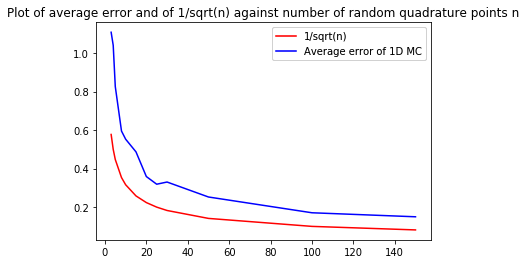

In [19]:
test_mc_int()

### Results from Monte-Carlo integration over reference triangle

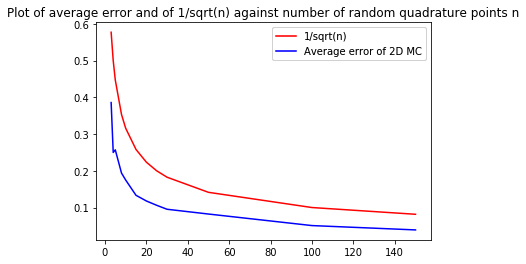

In [20]:
test_mc_tri()

# **Discussion**

Just as the theory predicts the Gauss quadrature is exact for cubic and quadratic polynomials over the unit interval and the reference triangle respectively. Whereas the Monte-Carlo integration is not exact for these polynomials, but if we look at of the error we se it they apart from multiplication by a constant closely resemble the plot of $1/\sqrt{n}$, where $n$ is the number of random quadrature points used, both in the 1D and 2D case. So, we conclude that the rate of convergece is $1/\sqrt{n}$, just as expected.